# Data understanding

In [1]:
import os
import cv2 as cv
import numpy as np
import tensorflow as tf 
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
DATA_PATH = 'Water_Bodies_Dataset' 
IMAGES_PATH = 'Water_Bodies_Dataset\Images' 
MASKS_PATH = 'Water_Bodies_Dataset\Masks' 

In [ ]:
!dir Water_Bodies_Dataset

In [ ]:
!dir Water_Bodies_Dataset\Images

In [ ]:
!dir Water_Bodies_Dataset\Masks

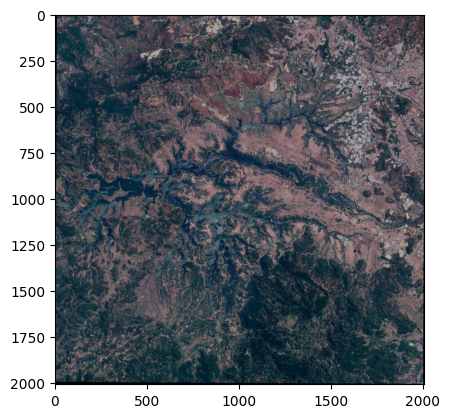

In [3]:
water_image = cv.cvtColor(cv.imread('Water_Bodies_Dataset\Images\water_body_1.jpg'), cv.COLOR_BGR2RGB)
plt.imshow(water_image)
plt.show(block=False)

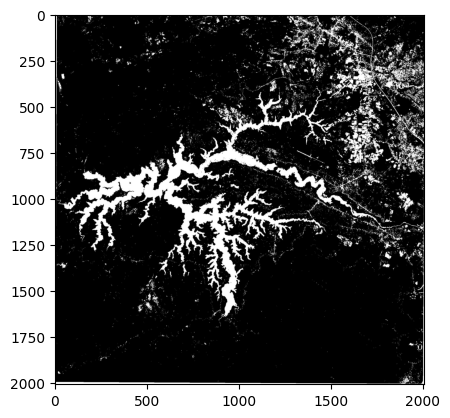

In [4]:
water_mask = cv.cvtColor(cv.imread('Water_Bodies_Dataset\Masks\water_body_1.jpg'), cv.COLOR_BGR2RGB)
plt.imshow(water_mask)
plt.show(block=False)

In [5]:
water_bodies_images = os.listdir(IMAGES_PATH)
mask_images = os.listdir(MASKS_PATH)

print(f'The number of images of water bodies is: {len(water_bodies_images)}')
print(f'The number of images of masks is: {len(mask_images)}')

The number of images of water bodies is: 2841
The number of images of masks is: 2841


# Image augmentation

In [6]:
filenames = os.listdir('Water_Bodies_Dataset\Images')

In [7]:
def reflection(image, axis, path):
    flipped_image = cv.flip(image, axis)
    cv.imwrite(path, flipped_image)

In [8]:
V_FLIP_IMAGE_PATH = "Water_Bodies_Dataset\V_Flip_Images"
V_FLIP_MASK_PATH = "Water_Bodies_Dataset\V_Flip_Masks"

H_FLIP_IMAGE_PATH ="Water_Bodies_Dataset\H_Flip_Images"
H_FLIP_MASK_PATH = "Water_Bodies_Dataset\H_Flip_Masks"

In [9]:
#save images flipped
def invert(flip_images_path, flip_masks_path, axis):
    for file in filenames:
        path_image = os.path.join(IMAGES_PATH, file)
        flip_path_image = os.path.join(flip_images_path, file) 
        image = cv.imread(path_image)
        reflection(image,axis, flip_path_image)
        
        path_mask = os.path.join(MASKS_PATH, file)
        flip_path_mask = os.path.join(flip_masks_path, file)  
        mask = cv.imread(path_mask)
        reflection(mask,axis, flip_path_mask)

In [10]:
#invert(H_FLIP_IMAGE_PATH,H_FLIP_MASK_PATH,1)

## Data loading

In [10]:
X = []
Y = []

In [11]:
filenames = os.listdir('Water_Bodies_Dataset\Images')

In [12]:
def load_images(filenames, images_path, masks_math):
    for file in filenames:

        path_image = os.path.join(images_path, file)
        img = tf.keras.utils.load_img(path_image, grayscale=False, color_mode='rgb', target_size=(128, 128,3))
        img_array = np.array(img)
        img_array = img_array/255
        X.append(img_array)


        path_mask = os.path.join(masks_math, file)
        mask = tf.keras.utils.load_img(path_mask, grayscale=False, color_mode = "grayscale", target_size=(128, 128,1))
        mask_array = np.array(mask)
        mask_array = mask_array/255
        Y.append(mask_array)

In [13]:
load_images(filenames, IMAGES_PATH, MASKS_PATH)
load_images(filenames, V_FLIP_IMAGE_PATH, V_FLIP_MASK_PATH)
load_images(filenames, H_FLIP_IMAGE_PATH, H_FLIP_MASK_PATH)

In [14]:
print(len(Y))
print(len(X))

8523
8523


In [15]:
print(type(Y[0]))
print(type(X[0]))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [16]:
print(Y[0].shape)
print(X[0].shape)

(128, 128)
(128, 128, 3)


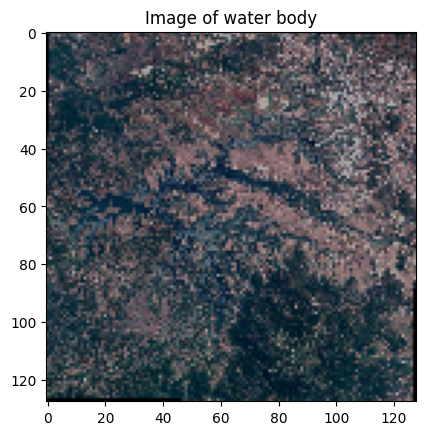

In [17]:
plt.imshow(X[0])
plt.title("Image of water body")
plt.show()

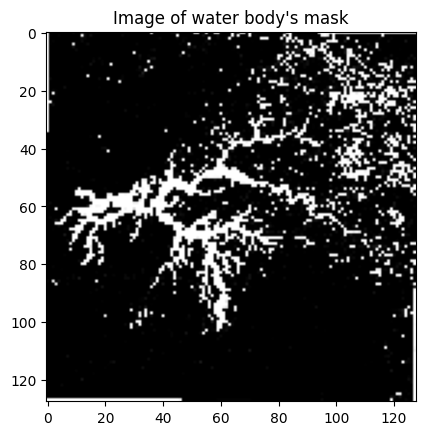

In [18]:
plt.imshow(Y[0], cmap='gray', vmin=0, vmax=1)
plt.title("Image of water body's mask")
plt.show()

In [19]:
X = np.array(X)
Y = np.array(Y)

In [20]:
Y = np.where(Y <= 0.5, 0, 1)

In [21]:
print(type(X))
print(type(Y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
#Split data on train, validation and test sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8, shuffle = True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.8, shuffle = True, random_state=42)

In [23]:
del X
del Y

In [26]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
print(len(X_val))
print(len(y_val))

6818
6818
1364
1364
341
341


In [27]:
X_train[0].shape
y_train[0].shape

(128, 128)

## Model Creation

In [28]:
def encoderBlock(n_filters, pooling=False):
    layer = keras.Sequential()
    
    initializer = keras.initializers.he_normal()
    
    layer.add(keras.layers.Conv2D(filters=n_filters,
                                  kernel_size=(3,3),
                                  strides=(1,1),
                                  padding="same",
                                  kernel_initializer=initializer))
    layer.add(keras.layers.BatchNormalization())
    layer.add(keras.layers.Activation('tanh'))
    #layer.add(keras.layers.LeakyReLU())
    
    if pooling:
        layer.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    
    return layer

In [29]:
def decoderBlock(n_filters, apply_dropout=False):
    layer = keras.Sequential()
    
    initializer = keras.initializers.he_normal()
    
    layer.add(keras.layers.Conv2DTranspose(filters=n_filters,
                                  kernel_size=(3,3),
                                  strides=2,
                                  padding="same",
                                  kernel_initializer=initializer))
    layer.add(keras.layers.BatchNormalization())
    layer.add(keras.layers.Activation('tanh'))
    
    if apply_dropout:
        layer.add(keras.layers.Dropout(0.3))
    
    return layer

In [30]:
def unet_model():
    input = keras.layers.Input(shape=(None, None,3))
    
    encoder = [
        encoderBlock(64), # (512,512,128)
        encoderBlock(128, True), # (256,256,128)
        encoderBlock(256, True),# (128,128,256)
        encoderBlock(512, True),# (64,64,256)
        #encoderBlock(512, True),# (32,32,512)
        #encoderBlock(512, True),# (16,16,512)
        encoderBlock(512, True),# (8,8,512)
        encoderBlock(512, True),# (4,4,512)
        encoderBlock(512, True),# (2,2,512)
        encoderBlock(512, True)# (1,1,512)
    ]
    
    decoder = [
        decoderBlock(512, apply_dropout=True),  # (2,2,512)
        decoderBlock(512, apply_dropout=True),  # (4,4,512)
        decoderBlock(512, apply_dropout=True),  # (8,8,512)
        decoderBlock(512),                      # (16,16,512)
        #decoderBlock(512),                      # (32,32,512)
        #decoderBlock(512),                      # (64,64,512)
        decoderBlock(256),                      # (128,128,256)
        decoderBlock(128),                      # (256,256,128)
        decoderBlock(64)                       # (512,512,64)
    ]
    
    initializer = keras.initializers.glorot_uniform()
    #initializer = keras.initializers.he_normal()
    
    last = keras.layers.Conv2D(filters=1,
                                  kernel_size=(3,3),
                                  strides=(1,1),
                                  padding="same",
                                  activation = "sigmoid",
                                  kernel_initializer=initializer)
    
    x = input
    o = []
    
    #concat = keras.layers.Concatenate()
    
    for layer in encoder:
        x = layer(x)
        o.append(x)
    
    o = reversed(o[:-1])
    
    for layer,ok in zip(decoder,o):
        x = layer(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x,ok])
    
    x = last(x)
    
    return tf.keras.Model(inputs=input, outputs=x)

In [31]:
METRICS = [
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

In [32]:
model = unet_model()
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [33]:
len(model.layers)

24

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 sequential (Sequential)        (None, None, None,   2048        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 sequential_1 (Sequential)      (None, None, None,   74368       ['sequential[0][0]']             
                                128)                                                          

In [35]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True,
                               mode='min',
                              )

In [ ]:
history = model.fit(X_train, y_train, batch_size=2, epochs=5, validation_data = (X_val, y_val), callbacks = [early_stopping])

In [37]:
model = keras.models.load_model("segmentation_model.keras")

In [38]:
prediction = model.predict(X_test)

In [ ]:
model.save('segmentation_model.keras')

In [39]:
reshaped_predictions = prediction.ravel()
reshaped_truth = y_test.ravel()

In [40]:
reshaped_predictions = np.where(reshaped_predictions <= 0.5, 0, 1)
reshaped_truth = np.where(reshaped_truth <= 0.5, 0, 1)

In [41]:
from sklearn.metrics import classification_report

print(classification_report(reshaped_truth, reshaped_predictions))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90  14918661
           1       0.81      0.75      0.78   7429115

    accuracy                           0.86  22347776
   macro avg       0.85      0.83      0.84  22347776
weighted avg       0.86      0.86      0.86  22347776



In [42]:
prediction = np.where(prediction <= 0.5, 0, 1)

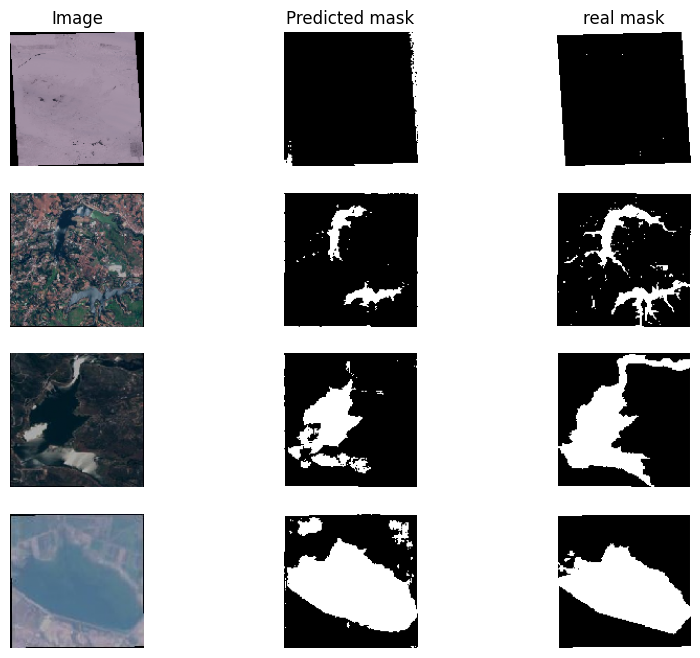

In [46]:
fig, axs = plt.subplots(4, 3, figsize=(10,8))
axs[0,0].imshow(X_test[10])
axs[0,0].set_title('Image')
axs[0,1].imshow(prediction[10], cmap='gray', vmin=0, vmax=1)
axs[0,1].set_title('Predicted mask')
axs[0,2].imshow(y_test[10], cmap='gray', vmin=0, vmax=1)
axs[0,2].set_title('real mask')

axs[1,0].imshow(X_test[13])
axs[1,1].imshow(prediction[13], cmap='gray', vmin=0, vmax=1)
axs[1,2].imshow(y_test[13], cmap='gray', vmin=0, vmax=1)

axs[2,0].imshow(X_test[2])
axs[2,1].imshow(prediction[2], cmap='gray', vmin=0, vmax=1)
axs[2,2].imshow(y_test[2], cmap='gray', vmin=0, vmax=1)

axs[3,0].imshow(X_test[4])
axs[3,1].imshow(prediction[4], cmap='gray', vmin=0, vmax=1)
axs[3,2].imshow(y_test[4], cmap='gray', vmin=0, vmax=1)

for ax_row in axs:
    for ax in ax_row:
        ax.axis('off')